<a href="https://colab.research.google.com/github/sanochkinl/ml2_course/blob/main/seminars/seminar_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Knowledge distillation

look into https://intellabs.github.io/distiller/knowledge_distillation.html for reference

In [10]:
!pip install transformers datasets timm

In [11]:
import torch
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np
import random
import os
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

#for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

set_seed()

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [12]:
import torch
from torch import nn
import torch.nn.functional as F


def train_fn(train_loader, model, criterion, optimizer, epoch, device):
    losses = AverageMeter()
    # switch to train mode
    model.train()
    for step, (images, labels) in enumerate(train_loader):
        # measure data loading time
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        y_preds = model(images)
        loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)
        loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), 1000)
        optimizer.step()
        optimizer.zero_grad()

        if step % 100 == 0 or step == (len(valid_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  .format(
                   epoch+1, step, len(train_loader), loss=losses,
                   grad_norm=grad_norm,
                   ))
    return losses.avg


def valid_fn(valid_loader, model, criterion, device):
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to evaluation mode
    model.eval()
    preds = []
    gt_labels = []
    for step, (images, labels) in enumerate(valid_loader):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        # compute loss
        with torch.no_grad():
            y_preds = model(images)
        loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)
        # record accuracy
        preds.append(y_preds.softmax(1).to('cpu').numpy())
        gt_labels.append(labels.to('cpu').numpy())
        if step % 100 == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(
                   step, len(valid_loader),
                   loss=losses,
                   ))
    predictions = np.concatenate(preds)
    gt_labels = np.concatenate(gt_labels)
    return losses.avg, predictions, gt_labels


def inference_func(model, testloader, device):
    correct = 0
    total = 0
    model.eval()
    preds = []
    gt_labels = []
    # since we're not training, we don't need to calculate the gradients for our outputs
    for step, (images, labels) in enumerate(testloader):
        images = images.to(device)
        labels = labels.to(device)
        # calculate outputs by running images through the network
        with torch.no_grad():
            outputs = model(images)
        preds.append(outputs.softmax(1).to('cpu').numpy().argmax(1))
        gt_labels.append(labels.to('cpu').numpy())
    predictions = np.concatenate(preds)
    gt_labels = np.concatenate(gt_labels)
    return predictions, gt_labels

In [13]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.RandomHorizontalFlip()
])

batch_size = 64

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

#val split
train_data, val_data = train_test_split(trainset, test_size=0.25, random_state=42)


train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size,
                                          shuffle=False, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [14]:
import timm

class ResNet(nn.Module):
    def __init__(self, model_name='resnet18', pretrained=False):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained)
        n_features = self.model.fc.in_features
        self.model.fc = nn.Linear(n_features, 10)

    def forward(self, x):
        x = self.model(x)
        return x

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

cuda:0


In [16]:
import torch.optim as optim

teacher_model = ResNet(model_name='resnet34', pretrained=True)
teacher_model.to(device)
optimizer = optim.Adam(teacher_model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

for epoch in range(5):  # loop over the dataset multiple times
    # train
    avg_loss = train_fn(train_loader, teacher_model, criterion, optimizer, epoch, device)
    # eval
    avg_val_loss, preds, val_labels = valid_fn(valid_loader, teacher_model, criterion, device)
    acc_score = accuracy_score(val_labels, preds.argmax(1))
    print(f"Validation accuracy for epoch {epoch} is {acc_score:.2f}")

print('Finished Training')

Epoch: [1][0/586] Loss: 2.2497(2.2497) Grad: 6.5535  
Epoch: [1][100/586] Loss: 1.4357(1.9442) Grad: 2.7849  
Epoch: [1][195/586] Loss: 1.2274(1.6479) Grad: 2.7652  
Epoch: [1][200/586] Loss: 1.3355(1.6369) Grad: 3.2524  
Epoch: [1][300/586] Loss: 1.2439(1.4538) Grad: 2.1474  
Epoch: [1][400/586] Loss: 0.8965(1.3249) Grad: 1.9394  
Epoch: [1][500/586] Loss: 0.9076(1.2311) Grad: 2.2591  
EVAL: [0/196] Loss: 0.6541(0.6541) 
EVAL: [100/196] Loss: 0.8874(0.7292) 
EVAL: [195/196] Loss: 1.0097(0.7312) 
Validation accuracy for epoch 0 is 0.75
Epoch: [2][0/586] Loss: 0.6220(0.6220) Grad: 1.6075  
Epoch: [2][100/586] Loss: 0.6498(0.6661) Grad: 2.0414  
Epoch: [2][195/586] Loss: 0.5228(0.6557) Grad: 1.5723  
Epoch: [2][200/586] Loss: 0.9139(0.6547) Grad: 2.1913  
Epoch: [2][300/586] Loss: 0.6079(0.6547) Grad: 1.5550  
Epoch: [2][400/586] Loss: 0.6828(0.6455) Grad: 1.7500  
Epoch: [2][500/586] Loss: 0.6820(0.6374) Grad: 1.6213  
EVAL: [0/196] Loss: 0.4128(0.4128) 
EVAL: [100/196] Loss: 0.6843(0.5

Knowledge distillation pipeline

<Axes: >

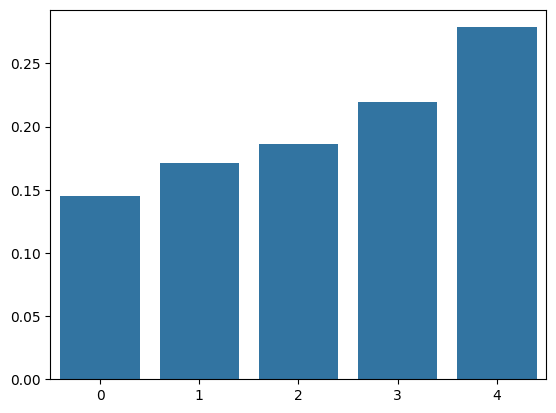

In [75]:
# @title Temperature Illustration { run: "auto" }
from seaborn import barplot

temp = 1.21 # @param {type:"slider", min:0.01, max:100, step:0.1}

barplot(F.softmax(torch.tensor([0.1, 0.3, 0.4, 0.6, 0.89]) / temp, dim=0).numpy())

In [46]:
import torch.nn as nn
import torch.nn.functional as F


def calculate_kd_loss(logits_student, logits_teacher, y_true, temp=1, distil_weight=.5):
    soft_teacher_out = F.softmax(logits_teacher, dim=1)
    soft_student_out = F.softmax(logits_student, dim=1)
    student_loss = F.cross_entropy(logits_student, y_true)
    distillation_loss =  F.cross_entropy(
        soft_student_out / temp, soft_teacher_out / temp
    ) * temp**2
    return (1 - distil_weight) * student_loss + distil_weight * distillation_loss


def train_student_with_kd(
        train_loader,
        criterion,
        optimizer,
        epochs,
        device,
        student_model,
        teacher_model,
    ):
        teacher_model.eval()
        student_model.train()
        loss_arr = []
        length_of_dataset = len(train_loader.dataset)
        best_acc = 0.0

        print("Training Student...")

        for ep in range(epochs):
            epoch_loss = 0.0
            correct = 0

            for (data, label) in train_loader:

                data = data.to(device)
                label = label.to(device)

                student_out = student_model(data)
                teacher_out = teacher_model(data)

                loss = calculate_kd_loss(student_out, teacher_out, label)

                if isinstance(student_out, tuple):
                    student_out = student_out[0]

                pred = student_out.argmax(dim=1, keepdim=True)
                correct += pred.eq(label.view_as(pred)).sum().item()

                loss.backward()
                grad_norm = torch.nn.utils.clip_grad_norm_(student_model.parameters(), 1000)
                optimizer.step()
                optimizer.zero_grad()

                epoch_loss += loss.item()

            avg_val_loss, preds, val_labels = valid_fn(valid_loader, student_model, nn.CrossEntropyLoss(), device)
            acc_score = accuracy_score(val_labels, preds.argmax(1))
            print(f"Validation accuracy for epoch {ep} is {acc_score:.2f}")



In [48]:
from functools import partial

student_model = ResNet(model_name='resnet18', pretrained=True)
student_model.to(device)
optimizer = optim.Adam(student_model.parameters(), lr=1e-3)
train_student_with_kd(
    train_loader,
    partial(calculate_kd_loss, temp=2, distil_weight=0.8),
    optimizer,
    10,
    device,
    student_model,
    teacher_model,
)

Training Student...
EVAL: [0/196] Loss: 0.5785(0.5785) 
EVAL: [100/196] Loss: 0.7044(0.7113) 
EVAL: [195/196] Loss: 1.2737(0.7134) 
Validation accuracy for epoch 0 is 0.75
EVAL: [0/196] Loss: 0.6966(0.6966) 
EVAL: [100/196] Loss: 0.7143(0.7244) 
EVAL: [195/196] Loss: 1.0807(0.7322) 
Validation accuracy for epoch 1 is 0.76
EVAL: [0/196] Loss: 0.5887(0.5887) 
EVAL: [100/196] Loss: 0.7085(0.6493) 
EVAL: [195/196] Loss: 0.8057(0.6611) 
Validation accuracy for epoch 2 is 0.79
EVAL: [0/196] Loss: 0.5028(0.5028) 
EVAL: [100/196] Loss: 0.5726(0.5860) 
EVAL: [195/196] Loss: 0.9814(0.5996) 
Validation accuracy for epoch 3 is 0.80
EVAL: [0/196] Loss: 0.5375(0.5375) 
EVAL: [100/196] Loss: 0.8499(0.6877) 
EVAL: [195/196] Loss: 1.1250(0.7013) 
Validation accuracy for epoch 4 is 0.79
EVAL: [0/196] Loss: 0.7315(0.7315) 
EVAL: [100/196] Loss: 0.7271(0.6848) 
EVAL: [195/196] Loss: 1.2397(0.6859) 
Validation accuracy for epoch 5 is 0.79
EVAL: [0/196] Loss: 0.5790(0.5790) 
EVAL: [100/196] Loss: 0.7438(0.6

## Active learning

![1_RMZMa6FpJ18i3u9DxP4LEw.png](attachment:8a877bcf-d42c-4f96-a8a8-23e9c457ffa0.png)